# Ch. 11 – Genre classification

## Figure 11.2. Illustration of genre classification with acoustic descriptors. Panel A and B: Distribution of RMSE and Spectral centroid values across 10 genres in all excerpts. Panel C: Confusion matrix of the random forest classification model showing the proportion of cases predicted in the actual and predicted genres.

## Summary

This notebook will look at a classic genre categorization study and
dataset by Tzanetakis & Cook (2002) and will conduct a simple
classification of genre based on acoustic features extracted from the
audio files. The full data contains 100 audio excerpts from 10 different
genres (1000 clips in total), but we are going to start with a smaller
set to keep this light to run. It should be noted that the selection of
the excerpts for this dataset were not particularly rigorous and
represented the collection of music that George Tzanetakis had at his
disposal at the time. And this dataset has some quirks and
imperfections, but I think it is still a fun, classic and illustrative
example to explore.

# Setup

# Load libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

## Load dataset

We first install `mirdata` library to the computer.

In [2]:
import sys
!{sys.executable} -m pip install mirdata

Then we initialise the library and download the audio excerpts needed. I
only take 100 excerpts here but you can take all 1000 excerpts by
altering the script below.

In [3]:
import mirdata
#print(mirdata.list_datasets())
gtzan_genre = mirdata.initialize('gtzan_genre')
gtzan = mirdata.initialize('gtzan_genre', version='mini')   # This is 100 excerpts
#gtzan = mirdata.initialize('gtzan_genre')                  # This is 1000 excerpts (uncomment if you want to analyse the full data)
gtzan.download()
print('Downloaded',len(gtzan.track_ids),'tracks')

INFO: Downloading ['mini', 'tempo_beat_annotations'] to /Users/tuomaseerola/mir_datasets/gtzan_genre
INFO: [mini] downloading main.zip
INFO: /Users/tuomaseerola/mir_datasets/gtzan_genre/main.zip already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [tempo_beat_annotations] downloading annot.zip
INFO: /Users/tuomaseerola/mir_datasets/gtzan_genre/annot.zip already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.

Downloaded 100 tracks

Let’s look at an example (`track ID 88`).

['Genre:', 'pop', 'Name:', 'pop.00008', 'Tempo:', 84.1]
22050

<source src="data:audio/wav;base64,UklGRiQwFABXQVZFZm10IBAAAAABAAEAIlYAAESsAAACABAAZGF0YQAwFACIQGM6UzgJNT81KzDwK6wpRisWJN8kSSSPH4Ah4CDcHXsbOh6uHEoTDxhDFAESBw9CB1ELaQpxBo0GiQfpB4YG+wbCBSoF+AbWCSEMchAgEt0R0hepFnofLBwnHE0eRRunHasZuREFFS4SZwxeB0QFEgiF+kX+NP589Cf5jvny9vj4n/eR+mP5Av03+tv6G/68+j78xfm7+J/6YvTi887zU+vo6kzsOuZw3//g4N4H2s7dhdfc1oPdSdnK2izg0NyG40/k7eX26S7q5u4K7yvtyPbB8cHrxvZ486b2JvM3+pz6gPiTAOf/nf1rBFEFWgrVC9gXrhPAGW4g9R8AIuooOiVnKYsiKyhbIwIeHyCTGk8bqhqBFG0TOBTSCvAO7QgADh4LhQv4EZIP7BBTFHIUfRWvF88XaRtrGIQXWBz0EwkZNBNOEFAS9wg5CsAFvP9LAlT+2v3L+5z3kPu5+f3ymfh5/Lv0D/bY+Br2DfXY89f3ZPGv8GTvYOuH58zmhOOX41TkL98N4Znejd453ZbfMOLU4TPoZ/Cf7LXxd/eJ+p0ARP+vBLsFfAGfAkb+/f5v+d35Avep8wjyzPDA6aXqBu7a54DmJ+5R7Z7xOe5a+DT2Avor/gf8ff4U/y8B9QHD/tECoAIpAPX/Df1T/qL6xPm/93zyAvOm7pvr6+406ZDuhucZ6D3t9uVh6UnmEOgu6tvi++dn4cPhQeJL2tbbd9y31jXZ69GI2WvTENAH1fDNkc8a0rPQzNcT1HLdiNqV4WXlIOW54xXrROYb6qbnzOBD5FbePODQ3dnUxNuw1ZnTQNalzvPVVdIU1rrbkNve3priwuUl7uzqO/Gs8VD18PoD9iz+nPdk/kL+hvgrAED92vhf+1f3Gvap84/2QvNY7zjy9e967vjwVu588CrxgvJL8NTym/Xb7xXzOvT+73vwnu7A7IzuGugD6pXoE+fn6U/n3Obs5gbq4enY9H3ypfva/jwDXQPMCx4M2hG4ETEW4hBwFdMP9hDnE9wMQhIHEscPIhHtEUUXHhYNHJ4iHCQBLT0xezgDPQ5F20j1UF1SBFbKW8dViVu/Wxla61ghVrpUnFKqS5hMF0VPRbBCQzpTPjA5xzNZODQ1eTO0M54wLTIeL4AuvCwRLc0qwSZLJ1EmXx/sHV4bVBypFEMXahbxEXcSDhE0Ef8MpA5gEcwRTBP4FJcYERivGzce4RxyJEgcUyDDH2Udnxq6GXAVERRmEuIQLg3dCM8LbwXUBSsEtQXUAfAGNAYfBwQH7QlUCzoIBQoMDWAJeQy4CPYIMwhkCCwCIgLNA7X5Wfwx+kHwDfDm7D/o0Ohy48fiU94M3kve/dsa2Bva2dbg1oXX5dNw08nUJNCP0y3PLM/30cDMktOC1TLR9Ntx2Ofe0OEF5R7qdPL1+EH6SgbpBh0OxxHUFQMffhplIXAjJyDmHbQj+h1aIAsjLh4RH5IcuxxJG10clRySHDYcIiFtH+EgkiZxJoMjuCwBJPMqgyfEKD8j1SIkIEAhgB34FR8Z6hIYD88NbwZhB5EC1gA8/n37Bf3e+hr59/3p+Jv3cvpI9B35RPfk9pbz4vcf82PxbPB975jwUe587Ajxa+vi7lbuIerr8u7v3vN4+xX4JvmdAj4AigEzBWsI5QekBDcIagOL/9P/gfxn+qr3tfns8u3zm/B289zxWO6r8vDvF/NW8a/05/Y99uT6TvuG+qEE7/0T/nQH/AGKBqsFZQbGBYUBdAR/AdT8HAIx9nv2Uvdc7tLww/Br76HvGu6p8ePvI+0n9Lzt8OtO8HznPOh45+bipuL13MbhWtkH21rckdIi2rbW1dFR0+La89uQ2gPj8uSM5Zzo9Otc7U7vPO7Y8ODsouyE7Ufqh+Ma527hCdwf42fbMNm53NPZVtub25naxNc13LfbmN7+3kzfsOJ65OXmmOhd6G3n+unz6kvqz+hK5PPn1OMo4/blc9+84azcq9wT3UTaXdrH2gzZkNws3djd3t124nfdEeE831Lf0+EK20Lfqd6d2obdXN0L3SDhjt/Q35DjIt++5ZnsBOrc86X1LvjVALL+0gTHAgcHjQmPBp0G9QkfBB0G7gSQAAcBl/+I/B//bPpv+cn6dvew/yv7dPz+/M8AiALYA4IGzgshDpMQJBWOGp4bBCDqJakq5CZXMZgwFzHVNkw2rTfEOm49ljwXN9NCnjp0Ps9B6j2uQ7FBq0FWQ0FB+0C7QDY/mD6KO6U2ETdcMhE03S/VL/4rvSwtJuApiiRVJMsnUSUMKoUrHS+zLmsyCTHBNDA1LDavNVc1FTKPMoowyCz6KQgo8ydlI0oePh/CHQoa0x2BIOcZPR5AIQUfhyGzI74jGSXiJ+MmeCSSKvclzSUZJ54kVR7THuQdahT0FOsRvwepCm0Dav28/jj0qfUv9K3vDO9P7RXsZew86OrnW+hL56ThIuFM337Yv9pR1KXSh9XAzpnQ99CHyrjSP8r3zzjR4cv62rvULNuW4+LgZOky7LDr1vOI9qLy4/hS+A37XfnV+1H9PPkJAIv90P3lAA0AJwFyAGAFygZ+CssLggzOElwV8BI9G6Ab0BynItog7iIYJUsifSfoJh8jNiS4IcYepx1iHGIYNxbGFDgQfRE/DewGUAmICBcFUwbnAucB5QWH/9v/Xv/y+tf3aPly9QXv9/HE7Ars0etC6m/m7+ZA5sri3+TJ6BnsHOwT8LD12PO0+qb5av3Y/8T/Wf2SAjEBAfmK/HT+dfdi+m33CPMb9LXxM/Go7p7vl/dg7SD2p/et8QL9QvyQ/BYDvADmAg8FTgawA48HaAa4B2YFjf9KA3T+h/aP+ZP1ovEu7Ofs9Oqx6HHgXObo5NHe9uTa3grfBeMx3dfimN7h3k/iXNsu24fcNddp3FnZ69qu3GjfEdhf4WLf9uBf5YPoDeoR8mfs1vaR+1b4XP41ArT8GwT4+xgAC/2C8x3+tO8+9dzuVO0s69roUeYp54jm+OT/4ivm+eMj5qPmwua/5pXpb+a967boyeif7OXo8euI7SHnUOhT5l7iVuTj24/c+NbZ1WfVJtEq067Nsc5p0jzLg9JL0hvRWdMo2FLatdey2zLdc9rF3EreftqT4DjblN8333DgjuP14crge+bl5KjrU+sI8RHyvPTt+fn1V/7n++z8Dv/j/Kj8y/vn/E/76frc/Lz3c/79+Fz75fnn+3L8Ivv0/OX/b//9A08EJAsrCNgLjw5LEPYS1BOeFH8VKBUNGzYUJxjlGbUT6xZdEyYSTQ4AEEYMEQcMDOMIcgkUCdgKqg/PC+4SVhSHFb4XYhxEHXkjHiSaJYcpETAYLCczTTJSNb00nTrAN8w21DrPPfg/rEPwRGRDa0quStdH8UyNUNdIH04qSWhJd0QzQ4c95j0wN/I3BDVaL8AyiysCLPsseykFLG0pQCmPLFUtgSkrKiwvCykeKxQqeSf/JxUmgyQnJ/ghsCP6HwEhah8DGisbJBZlE+YRsQvgC8UIvQUIAgME4f4U/I78Qfn+9/70pPZk8CXyCfBh63/tv+qg7Oro7Oc27GPofucK6C3oIuhK5zDsw+zx7Q/sWvCw77Lu++zz8uDsdu/h7hXnTul75wvjQ+EE34Tfft2S2sLb2tpt2vXdmN4m4Qnm5eJY6sXv9vCq9mX9/PvuA1EGJQjYDoUP+RJEFsQVdhlXGhodMh85HoAeIyLgGwMbIx90GsAYnhiZFXMUShJ2Ff4QBQ03D5oMpwn/CLgGTAPH/zQCiftRA7v/3/ml/VX7kPhg+BL3w/fK+b76OvrZ/Rz87f/DAycDWQJfB0oAzAUmAgEEOP+1/5n9Ifpx+8X4qfc29KD4ffVy9jH7GvhP+7L/kv9AAUYEhAReBHYJEwdvDOYHQQpRCv4HDwp+B

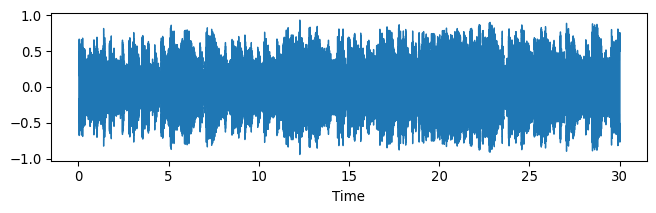

In [4]:
ID = 88
tracks = gtzan.load_tracks()
ex = tracks[gtzan.track_ids[ID]]
print(["Genre:", ex.genre, "Name:", ex.track_id, "Tempo:",ex.tempo,])
print(ex.audio[1])
plt.figure(figsize=(8, 2))
librosa.display.waveshow(y = ex.audio[0], sr = ex.audio[1])
ipd.display(ipd.Audio(data = ex.audio[0], rate = ex.audio[1]))

# Extract features

Let’s extract some features and use them to predict genres. We take some
rhythm features, some timbral features, \_MFCC_s (19 in total), and
*chromas* (12 in total). In the feature extraction, we calculate the
features across the 30-second excerpt and then just take the mean to
represent the feature.

The summary of the track could be more sophisticated (one could take the
median, and the standard deviation, for instance, or to avoid extreme
values, or to take multiple measures from within each example, and using
*bagging* or *voting* where separate clips are used in assessing the
most likely genre. This latter goes close to [ensemble machine-learning
techniques](https://en.wikipedia.org/wiki/Ensemble_learning)).

In [5]:
df = pd.DataFrame(columns = ['genre','bpm','rmse', 'spec_cent','spec_bw','rolloff','zcr','spec_ctr','mfcc1','mfcc2','mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12','mfcc13','mfcc14','mfcc15','mfcc16','mfcc17','mfcc18','mfcc19','chroma1','chroma2','chroma3','chroma4','chroma5','chroma6','chroma7','chroma8','chroma9','chroma10','chroma11','chroma12'])
for track in tqdm(tracks):
  ex = tracks[track]
  y, sr = librosa.load(ex.audio_path)
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  rmse = librosa.feature.rms(y=y)
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(y)
  spec_ctr = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=512)
  chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  df.loc[len(df)] = [ex.genre,ex.tempo,np.mean(rmse),np.mean(spec_cent),np.mean(spec_bw),np.mean(rolloff),np.mean(zcr),np.mean(spec_ctr),np.mean(mfcc[1]),np.mean(mfcc[2]),np.mean(mfcc[3]),np.mean(mfcc[4]),np.mean(mfcc[5]),np.mean(mfcc[6]),np.mean(mfcc[7]),np.mean(mfcc[8]),np.mean(mfcc[9]),np.mean(mfcc[10]),np.mean(mfcc[11]),np.mean(mfcc[12]),np.mean(mfcc[13]),np.mean(mfcc[14]),np.mean(mfcc[15]),np.mean(mfcc[16]),np.mean(mfcc[17]),np.mean(mfcc[18]),np.mean(mfcc[19]),np.mean(chroma[0]),np.mean(chroma[1]),np.mean(chroma[2]),np.mean(chroma[3]),np.mean(chroma[4]),np.mean(chroma[5]),np.mean(chroma[6]),np.mean(chroma[7]),np.mean(chroma[8]),np.mean(chroma[9]),np.mean(chroma[10]),np.mean(chroma[11])]

## Explore features

Let’s look at some of features across genres. Are there differences in
*dynamics* or *brightness*?

       rmse    spec_cent      spec_bw      rolloff       zcr   spec_ctr
0  0.036233  1505.357461  1559.228895  2717.238764  0.098223  23.372866
1  0.030610  1361.006486  1441.739951  2389.011463  0.087766  25.186866
2  0.043828  1490.274810  1600.005082  2785.418914  0.090046  22.894315
3  0.029426  1526.628932  1499.462050  2916.150271  0.108946  25.663545

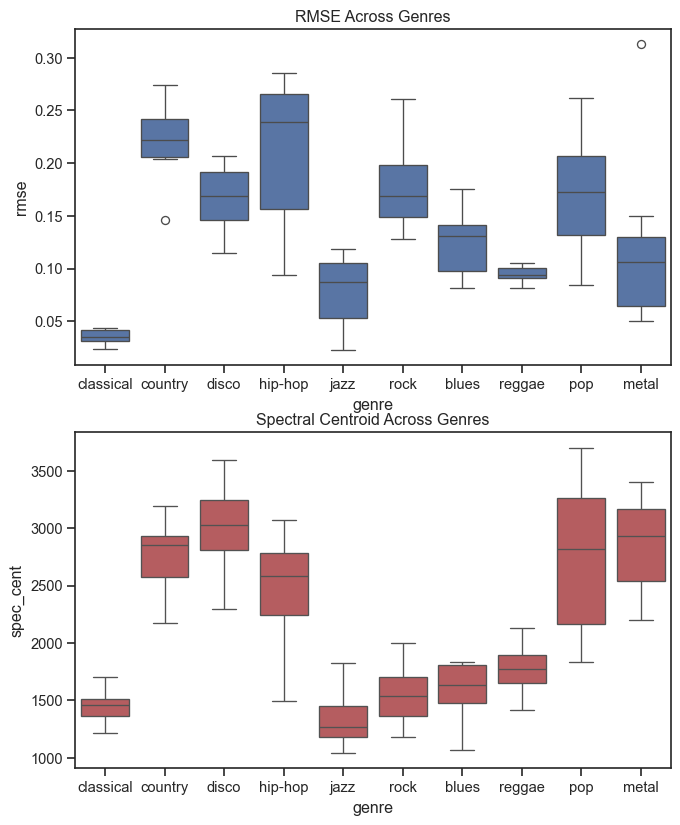

## Feature space

How large is our feature space and do have features that are redundant,
that is highly similar to each other? This can be easily explored by
visualising the correlations between all features.

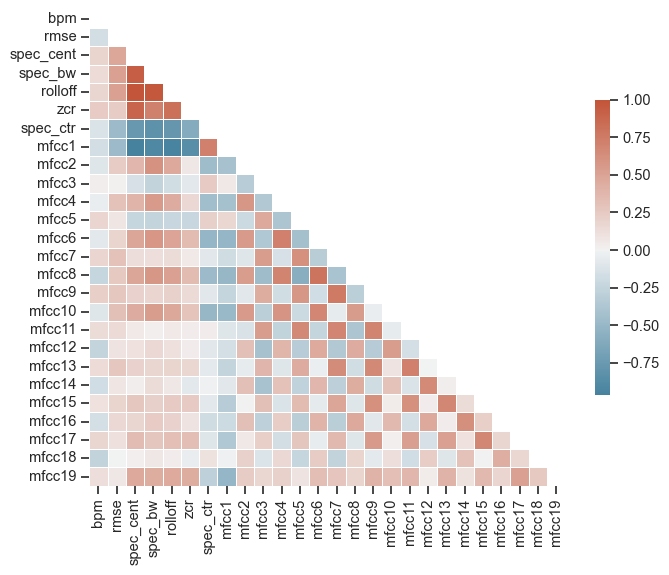

In [7]:
corr = df.iloc[0:99,1:27].corr() # Compute the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))       # Generate a mask for the upper triangle
f, ax = plt.subplots(figsize=(8, 8))                # Define matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Custom colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.00, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) # Draw the heatmap with the mask and correct aspect ratio
plt.show()

Classification and machine-learning algorithms typically deal well with
numerous features, but here we have only 100 observations and 39
variables, which is not a healthy proportion (too many variables
compared to observations). Usually it is a good idea to have 10:1 or
15:1 or even 20:1 of observations to predictors. Based on the
correlation matrix, what would you eliminate?

For instance, all chroma features have high positive correlations and
some of the timbral features seem to be related. Let’s trim the
selection as we have quite a little data when using the mini dataset.

In [8]:
df_trimmed = df.iloc[:,0:22]

# Classify with the features

We use all the features and relatively simple hierarchical
classification tree model called [random
forest](https://www.sciencedirect.com/topics/computer-science/random-forest-classifier).
It creates a bunch of decision nodes based on the data by using a subset
of the features and bootstrapping this process many times over. It is a
robust technique and does not really whether the distribution are normal
or not.

Before running the model, there are three operations to introduce that
are part of the good practice for model construction.

## Cross-validation of the model

We
[cross-validate](https://scikit-learn.org/stable/modules/cross_validation.html)
the model, which means that we split the data into *training* and
*testing sets*. We first train the model on the *training set*, which
here is a randomly select 70% of the data. Once we have trained the
model, we test it against the unseen data (*test set*, 30% of the data)
to assess how the model performs. This could be done by alterning the
selection of the training and testing set and we could do this 10 times
and average the results (this is called *k-fold cross-validation*).

## Stratifying the sample

When we randomly split the data into training and testing sets, we might
want to *stratify* the data according to genre, which makes sure that we
have similar proportion of examples from each genre at both sets.

## Normalize variables

We also want to normalize the variables. This is not so crucial for the
random forest model that we are going to use, but usually it is good
idea to eliminate the differences the feature ranges have to the model.
To normalize the variables, we turn them into z-scores, where the mean
is 0 and standard deviation is 1.

In [9]:
import pandas as pd
import sklearn as sk
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

X = df_trimmed.drop('genre', axis = 1)
Xn = preprocessing.normalize(X)
y = df_trimmed['genre']

test_size = 0.30 # taking 70:30 training and test set
seed = 9  # Random numbmer seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=test_size, random_state=seed,stratify=y)

RF = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0).fit(X_train, y_train)
#RF.predict(X_test)
#print(round(RF.score(X_test, y_test), 4))
y_pred_test = RF.predict(X_test)

And we have the results:

In [10]:
print('Correct classification rate:',round(RF.score(X_test, y_test), 4))

Correct classification rate: 0.7

In order to answer this question, you should think what a model that
predicts nonsense would achieve by chance? You could also check how this
model compares to the work published by Tzanetakis. Finally, might want
to consider what is level of accuracy expected from listeners and there
might be even studies about this to give you a benchmark.

# Analyse the model

Let’s look at this model in more detail and try to see which features
are doing the most heavy lifting here and could we simplify the model
and what kind of mistakes does the classification model make.

## Visualise confusion matrix

Let’s explore what kind of mistakes the model makes. Confusion matrix is
a useful way to visualise this.

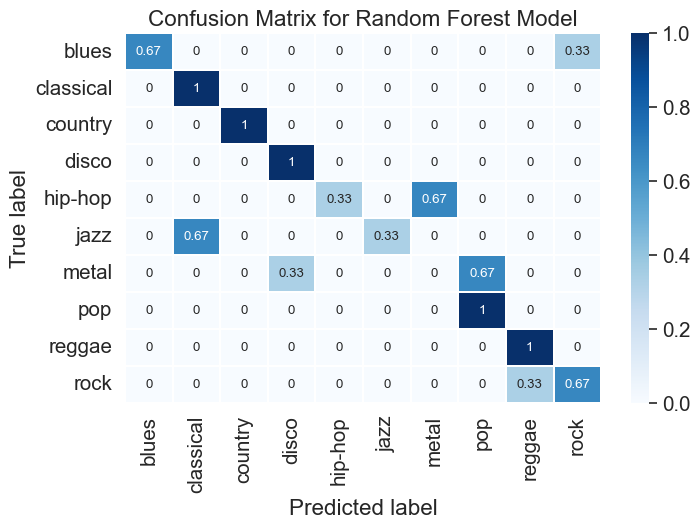

In [11]:
import seaborn as sns

# Reshape
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(8,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = RF.classes_ #np.unique(y_test)
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+0.5, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## Feature importance

Let’s plot the feature importance from random forest classification.

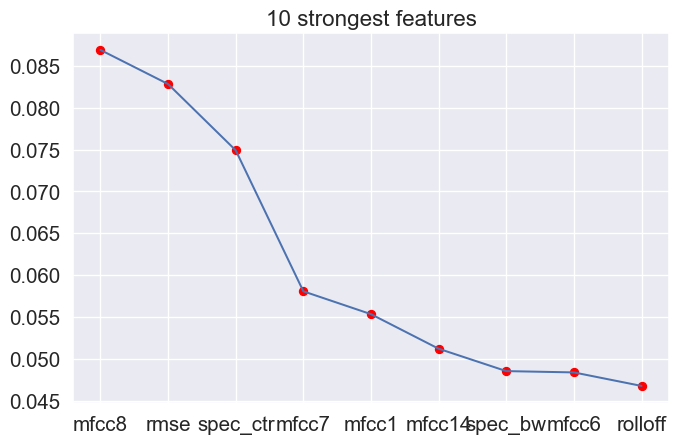

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

importance = RF.feature_importances_
n = df_trimmed.columns[1:len(df.columns)]
im = pd.DataFrame({'data': importance,'names': n})
im2 = im.sort_values(by='data',ascending=False)
# plot feature importance
fig, ax = plt.subplots(figsize=(8, 5))
#figure(figsize=(10, 5))
plt.scatter(im2.names[0:9],im2.data[0:9],color='red')
plt.plot(im2.names[0:9],im2.data[0:9])
ax.set_title('10 strongest features')
plt.show()

The plot show the best 10 features and the first four seem to bring
greater benefit to the model.

## Simplify model

What happens if we take the four best features and try building a
simpler model with these features?

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X2 = df_trimmed.filter(['mfcc8','rmse', 'spec_ctr', 'mfcc7'])

test_size = 0.30 # taking 70:30 training and test set
seed = 2022  # Random numbmer seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=test_size, random_state=seed,stratify=y)

RF = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=seed).fit(X_train, y_train)
RF.predict(X_test)
# Make predictions for the test set
y_pred_test = RF.predict(X_test)
print(round(RF.score(X_test, y_test), 4))

0.6333

What do you think about the simplified model with 5 features? Is the
model still good? You could look at the confusion to see what kind of
mistakes the slimmer model starts to make.

There is concept call *principle of parsimony* or the idea behind that
simpler models are more parsimonius than complex models, which stems
from *Occam’s razor*. There are several statistical measures that assess
the model fit and parsimoniousness ([Akaike Information
Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)
etc.). We are not entering into those calculations here but usually it
is better to have a simple model and compromise the model accuracy a
little bit than to gain few points in accuracy but having a complex
model.

## Summary

There numerous other algorithms to classify the materials, SVMs
([Support Vector
Machines](https://scikit-learn.org/stable/modules/svm.html)), [K-nearest
neighbour models
(KNNs)](https://scikit-learn.org/stable/modules/neighbors.html), [Neural
networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html),
and many others.

We could have focussed more on features, their calculation, the summary
measures, and subsets, but overall we achieved a good success with a
small set of features. We have to remember that this is a mini-version
of the original dataset. You are welcome to try how the full dataset
would improve the results.

This process is pretty generic for all kinds of classification tasks, so
the same procedure could be applied to prediction *emotion categories*,
*meter*, *instrumentation* and other properties of music.

# References

-   Tzanetakis, G. & Cook, P. (2002). Musical genre classification of
    audio signals. *IEEE Transactions on Speech and Audio Processing,
    10(5)*, 293-302
    [doi:10.1109/TSA.2002.800560](https://ieeexplore.ieee.org/document/1021072).